In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_log_error,mean_squared_error,roc_auc_score
from sklearn import metrics
from sklearn.linear_model import SGDRegressor,LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.pipeline import Pipeline
from math import sqrt
from scipy.sparse import csr_matrix, hstack
from sklearn.svm import SVR
from sklearn import preprocessing
import xgboost as xgb
from sklearn.decomposition import PCA

In [98]:
data = pd.read_csv('./data/Data_Train.csv')

In [99]:
data.head()

,Unique_ID,Name,Genre,Country,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers
0,413890,Hardstyle,danceedm,AU,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45.000000,14017,4,499,97,119563
1,249453,Dj Aladdin,danceedm,AU,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52.000000,1918,17,49,17,2141
2,681116,Maxximize On Air,danceedm,AU,Maxximize On Air - Mixed by Blasterjaxx - Epis...,2015-05-08 17:45:59.000000,9668,11,312,91,22248
3,387253,GR6 EXPLODE,rbsoul,AU,MC Yago - Tenho Compromisso (DJ R7),2017-06-08 23:50:03.000000,113036,2,"2,400",76,393655
4,1428029,Tritonal,danceedm,AU,Escape (feat. Steph Jones),2016-09-17 20:50:19.000000,110024,81,"3,031",699,201030


In [100]:
data.drop(columns=['Unique_ID','Country','Name'],axis=1,inplace=True)

In [101]:
data.head()

,Genre,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers
0,danceedm,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45.000000,14017,4,499,97,119563
1,danceedm,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52.000000,1918,17,49,17,2141
2,danceedm,Maxximize On Air - Mixed by Blasterjaxx - Epis...,2015-05-08 17:45:59.000000,9668,11,312,91,22248
3,rbsoul,MC Yago - Tenho Compromisso (DJ R7),2017-06-08 23:50:03.000000,113036,2,"2,400",76,393655
4,danceedm,Escape (feat. Steph Jones),2016-09-17 20:50:19.000000,110024,81,"3,031",699,201030


In [102]:
#data = pd.get_dummies(data,columns=['Genre'],drop_first=True)

In [103]:
data.head()

,Genre,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers
0,danceedm,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45.000000,14017,4,499,97,119563
1,danceedm,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52.000000,1918,17,49,17,2141
2,danceedm,Maxximize On Air - Mixed by Blasterjaxx - Epis...,2015-05-08 17:45:59.000000,9668,11,312,91,22248
3,rbsoul,MC Yago - Tenho Compromisso (DJ R7),2017-06-08 23:50:03.000000,113036,2,"2,400",76,393655
4,danceedm,Escape (feat. Steph Jones),2016-09-17 20:50:19.000000,110024,81,"3,031",699,201030


In [104]:
data['Timestamp'] =pd.to_datetime(data['Timestamp'])
data['dayofweek'] = data['Timestamp'].dt.dayofweek #but mostly people on weekend
data['weekend'] = data['dayofweek'].apply(lambda x: 1 if (x>4)  else 0)
display(data.groupby(['dayofweek'])['Views'].mean())
display(data.groupby(['weekend'])['Views'].mean())

dayofweek
0    464738.026194
1    490431.424895
2    492227.829528
3    527652.001258
4    712625.466029
5    447178.314718
6    603471.317145
Name: Views, dtype: float64

weekend
0    551470.332289
1    517781.487123
Name: Views, dtype: float64

In [105]:
data.describe()
#if mean and median not equal outliers ??

,Views,Comments,Followers,dayofweek,weekend
count,7.845800e+04,78458.000000,7.845800e+04,78458.000000,78458.000000
mean,5.469686e+05,115.270973,4.787663e+05,2.579609,0.133626
std,3.883085e+06,724.614868,1.168120e+06,1.785213,0.340252
min,0.000000e+00,0.000000,1.000000e+00,0.000000,0.000000
25%,6.216500e+03,1.000000,1.770000e+04,1.000000,0.000000
50%,2.538650e+04,12.000000,8.768200e+04,3.000000,0.000000
75%,1.201342e+05,61.000000,3.936550e+05,4.000000,0.000000
max,1.994050e+08,104082.000000,9.789123e+06,6.000000,1.000000


In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78458 entries, 0 to 78457
Data columns (total 10 columns):
Genre         78458 non-null object
Song_Name     78457 non-null object
Timestamp     78458 non-null datetime64[ns]
Views         78458 non-null int64
Comments      78458 non-null int64
Likes         78458 non-null object
Popularity    78458 non-null object
Followers     78458 non-null int64
dayofweek     78458 non-null int64
weekend       78458 non-null int64
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 6.0+ MB


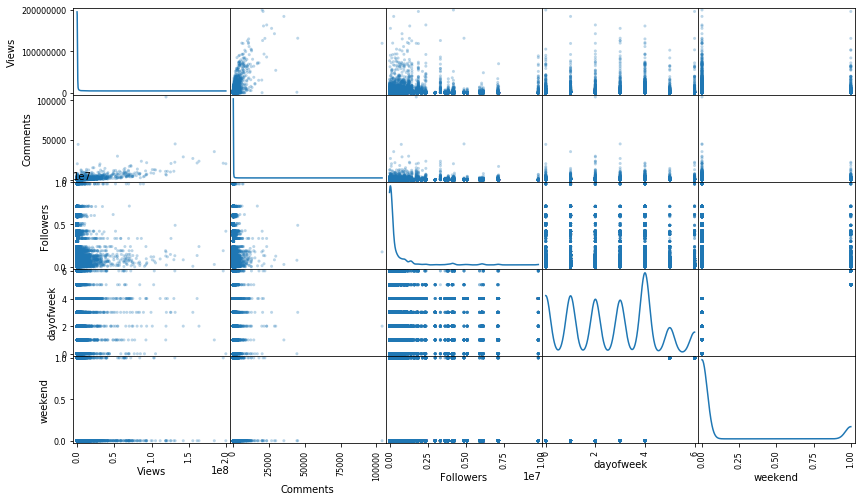

In [107]:
#pd.plotting.scatter_matrix(data, alpha=0.3, figsize=(14,8), diagonal='kde');

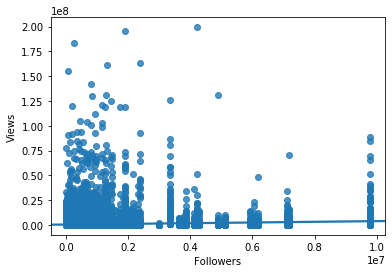

In [78]:
#sns.regplot(x="Likes", y="Views", data=data)
#sns.regplot(x="Comments", y="Views", data=data)
#sns.regplot(x="Popularity", y="Views", data=data)
sns.regplot(x="Followers", y="Views", data=data)

In [79]:
def popularityConverting(x):
    if x[-1]=='K':
        x= ''.join(x[:-1].split(','))
        x=float(x)*1000
    elif x[-1]=='M':
        x= ''.join(x[:-1].split(','))
        x=float(x)*1000000
    else:
        x= ''.join(x.split(','))
    return x

In [80]:
data['Popularity'] = data.Popularity.apply(popularityConverting)
data['Popularity'] = data.Popularity.astype('float')
data['Likes'] = data.Likes.apply(popularityConverting)
data['Likes'] = data.Likes.astype('float')
data.head()

,Genre,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers,dayofweek,weekend
0,danceedm,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45,14017,4,499.0,97.0,119563,4,0
1,danceedm,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52,1918,17,49.0,17.0,2141,0,0
2,danceedm,Maxximize On Air - Mixed by Blasterjaxx - Epis...,2015-05-08 17:45:59,9668,11,312.0,91.0,22248,4,0
3,rbsoul,MC Yago - Tenho Compromisso (DJ R7),2017-06-08 23:50:03,113036,2,2400.0,76.0,393655,3,0
4,danceedm,Escape (feat. Steph Jones),2016-09-17 20:50:19,110024,81,3031.0,699.0,201030,5,1


In [81]:
data.corr()

,Views,Comments,Likes,Popularity,Followers,dayofweek,weekend
Views,1.000000,0.679104,0.980132,0.834635,0.103603,0.014646,-0.002952
Comments,0.679104,1.000000,0.656645,0.641815,0.085034,-0.001844,-0.002394
Likes,0.980132,0.656645,1.000000,0.869048,0.110321,0.014117,-0.006747
Popularity,0.834635,0.641815,0.869048,1.000000,0.138454,-0.006822,-0.013047
Followers,0.103603,0.085034,0.110321,0.138454,1.000000,-0.031933,-0.076020
dayofweek,0.014646,-0.001844,0.014117,-0.006822,-0.031933,1.000000,0.631842
weekend,-0.002952,-0.002394,-0.006747,-0.013047,-0.076020,0.631842,1.000000


In [82]:
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)
data['Song_Name']=data['Song_Name'].astype('str')
data['Song_Name'] = data['Song_Name'].apply(text_process)

In [83]:
data['Song_Name'].head()

0    NVitral presents BOMBSQUAD Poison Spitter Snak...
1              Dj Aladdin Old School Hip Hop Quick Mix
2          Maxximize Air Mixed Blasterjaxx Episode 048
3                      MC Yago Tenho Compromisso DJ R7
4                              Escape feat Steph Jones
Name: Song_Name, dtype: object

In [84]:
#trying for time as feature
display(data[data['Timestamp']==data['Timestamp'].min()])
display(data[data['Timestamp']==data['Timestamp'].max()])
data.sort_values(by=['Timestamp']).groupby(['Timestamp'])['Views'].value_counts()
#data=pd.get_dummies(data,columns=['Genre'],drop_first=True)

,Genre,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers,dayofweek,weekend
8583,rock,Fairy King,1973-01-01,141,1,5.0,0.0,70299,0,0
14326,rock,Liar BBC,1973-01-01,87,0,0.0,0.0,70299,0,0
14653,rock,Keep Alive,1973-01-01,1086,0,14.0,0.0,70299,0,0
49988,rock,Right,1973-01-01,618,0,14.0,0.0,70299,0,0
61074,rock,Great King Rat,1973-01-01,104,0,0.0,0.0,70299,0,0


,Genre,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers,dayofweek,weekend
72376,danceedm,Sam Feldt Heartfeldt Radio 164,2019-02-25 08:00:06,35,0,7.0,3.0,23043,0,0


Timestamp            Views
1973-01-01 00:00:00  87       1
                     104      1
                     141      1
                     618      1
                     1086     1
                             ..
2019-02-25 03:59:34  1        1
2019-02-25 04:14:28  5        1
2019-02-25 04:15:07  1        1
2019-02-25 07:49:53  60       1
2019-02-25 08:00:06  35       1
Name: Views, Length: 78193, dtype: int64

In [85]:
data['Song_Name_length'] = data['Song_Name'].apply(lambda x:len(x))
data.head()

,Genre,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers,dayofweek,weekend,Song_Name_length
0,danceedm,NVitral presents BOMBSQUAD Poison Spitter Snak...,2018-03-30 15:24:45,14017,4,499.0,97.0,119563,4,0,62
1,danceedm,Dj Aladdin Old School Hip Hop Quick Mix,2016-06-20 05:58:52,1918,17,49.0,17.0,2141,0,0,39
2,danceedm,Maxximize Air Mixed Blasterjaxx Episode 048,2015-05-08 17:45:59,9668,11,312.0,91.0,22248,4,0,43
3,rbsoul,MC Yago Tenho Compromisso DJ R7,2017-06-08 23:50:03,113036,2,2400.0,76.0,393655,3,0,31
4,danceedm,Escape feat Steph Jones,2016-09-17 20:50:19,110024,81,3031.0,699.0,201030,5,1,23


In [86]:
features_data =data.loc[:,['Comments', 'Likes', 'Popularity', 'Followers','weekend','Song_Name_length','dayofweek']]
X = data.loc[:,['Comments', 'Likes', 'Popularity', 'Followers','weekend','Song_Name_length','dayofweek']]
y = data['Views']
X= StandardScaler().fit(X).transform(X)
X.shape

(78458, 7)

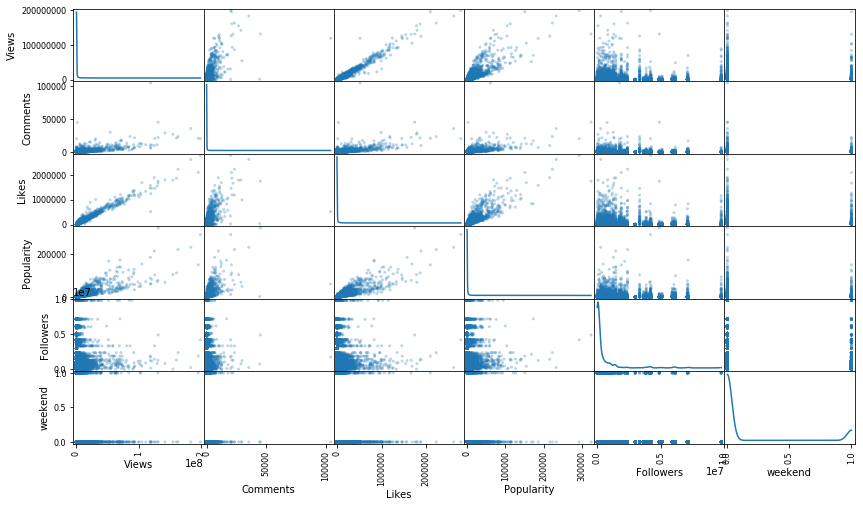

In [87]:
pd.plotting.scatter_matrix(data.loc[:,['Views','Comments', 'Likes', 'Popularity', 'Followers','weekend']], alpha=0.3, figsize=(14,8), diagonal='kde');

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

[0.35093244 0.23429078 0.14461361 0.13660415 0.06420646 0.05250922
 0.01684334]
[0.35093244 0.58522322 0.72983683 0.86644098 0.93064744 0.98315666
 1.        ]


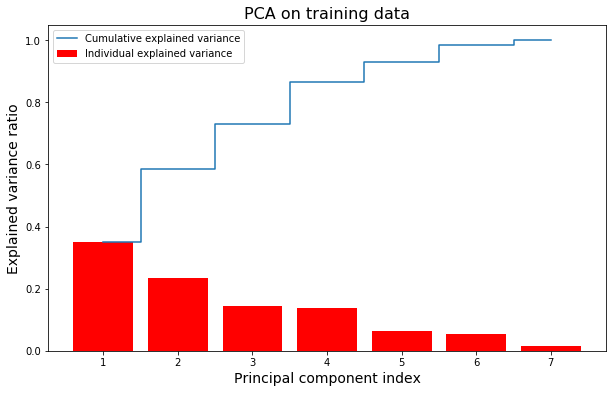

In [89]:
# Build PCA using standarized trained data
pca = PCA(n_components=None, svd_solver="full")
pca.fit(StandardScaler().fit_transform(X_train))
print(pca.explained_variance_ratio_)
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(range(1, 8), pca.explained_variance_ratio_, align="center",
        color='red', label="Individual explained variance")
plt.step(range(1, 8), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.xticks(range(1, 8))
plt.legend(loc="best")
plt.xlabel("Principal component index", {"fontsize": 14})
plt.ylabel("Explained variance ratio", {"fontsize": 14})
plt.title("PCA on training data", {"fontsize": 16});
print(cum_var_exp)

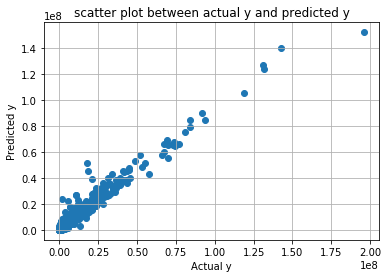

RMSE: 719412.656460


In [90]:
lr_regressor =LinearRegression()
lr_regressor.fit(X_train, y_train)
preds = lr_regressor.predict(X_test)
plt.scatter(y_test,preds)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))


In [91]:
lasso_params = {'alpha':[0.005,0.001, 0.02, 0.03, 0.05, 0.06]}
laso_regressor=Lasso()
laso_regressor_cv=GridSearchCV(laso_regressor,lasso_params,cv=5)
laso_regressor_cv.fit(X,y)
print("tuned hpyerparameters :(best parameters) ",laso_regressor_cv.best_params_)
print("accuracy :",laso_regressor_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'alpha': 0.001}
accuracy : 0.961297665717092


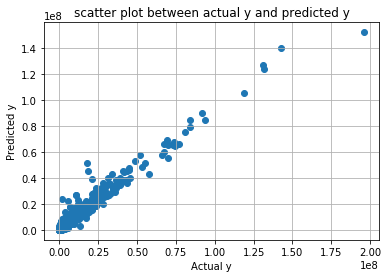

RMSE: 719412.656305


In [92]:
laso_regressor =Lasso(alpha= 0.001)
laso_regressor.fit(X_train, y_train)
preds = laso_regressor.predict(X_test)
plt.scatter(y_test,preds)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

In [93]:
rf_regressor= RandomForestRegressor()
hyperparam_grid={"n_estimators": [10, 50, 100],"max_features": ["sqrt", "log2", 0.4, 0.5],\
                 "min_samples_leaf": [1, 3, 5],"max_depth":[5,10,15,30]}
rf_regressor_cv = GridSearchCV(rf_regressor,hyperparam_grid,cv=2)
rf_regressor_cv.fit(X,y)
print("tuned hpyerparameters :(best parameters) ",rf_regressor_cv.best_params_)
print("accuracy :",rf_regressor_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 100}
accuracy : 0.9601636295071233


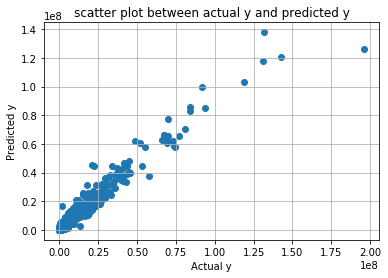

RMSE: 772340.745064


In [108]:
rf_regressor=RandomForestRegressor(max_features= 0.4, min_samples_leaf= 1, n_estimators=100)
rf_regressor.fit(X_train,y_train)

preds = rf_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
plt.scatter(y_test,preds)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print("RMSE: %f" % (rmse))

[4 6 5 3 0 2 1]
[1 2 0 3 5 6 4]


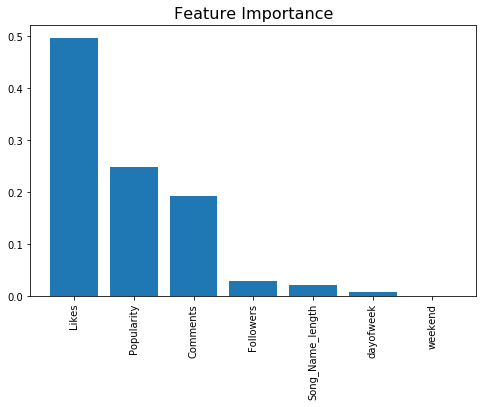

In [109]:
feature_importance = rf_regressor.feature_importances_
print(np.argsort(rf_regressor.feature_importances_))
indices = np.argsort(rf_regressor.feature_importances_)[::-1]
print(indices)
plt.figure(figsize=(8, 5))
plt.xticks(range(1, 8), features_data.columns[indices], rotation=90)
plt.bar(range(1, 8), feature_importance[indices], align="center")
plt.title("Feature Importance", {"fontsize": 16});

In [96]:
xgb_regressor=xgb.XGBRegressor()

n_estimators = [100, 500]
max_depth = [2, 3, 5, 10, 15]
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    }

# Set up the random search with 4-fold cross validation
xgb_regressor_cv = RandomizedSearchCV(estimator=xgb_regressor,
            param_distributions=hyperparameter_grid,
            cv=2,
            scoring = 'neg_mean_absolute_error',
            return_train_score = True,
            random_state=42)
xgb_regressor_cv.fit(X_train,y_train)
xgb_regressor_cv.best_estimator_

[21:23:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:24:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:24:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:24:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:24:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:24:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:24:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:24:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:25:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

KeyboardInterrupt: 

In [ ]:
#regressor=xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100, min_child_weight=3, max_depth=10, learning_rate=0.1, booster='gbtree', base_score=0.25)
xgb_regressor= xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
xgb_regressor.fit(X_train,y_train)

preds = xgb_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
plt.scatter(y_test,preds)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print("RMSE: %f" % (rmse))

In [ ]:
#outliers
xgb_regressor.feature_importances_

In [ ]:
feature_importance = xgb_regressor.feature_importances_
print(np.argsort(xgb_regressor.feature_importances_))
indices = np.argsort(xgb_regressor.feature_importances_)[::-1]
print(indices)
plt.figure(figsize=(8, 5))
plt.xticks(range(1, 6), features_data.columns[indices], rotation=90)
plt.bar(range(1, 6), feature_importance[indices], align="center")
plt.title("Feature Importance", {"fontsize": 16});

In [ ]:
estimators = {"Linear Regressor": lr_regressor,
              "Lasso Regressor": laso_regressor,
              "Random Forest Regressor": rf_regressor,
              "XGB Regressor": xgb_regressor}
for estimator in estimators.keys():
    print('RMSE {}:{:.2f}'.format(estimator,np.sqrt(mean_squared_error(y_test, estimators[estimator].predict(X_test)))))

In [ ]:
data_test = pd.read_csv('./Data_Test.csv')
display(data_test.head())
label= data_test['Unique_ID']
data_test.drop(columns=['Unique_ID','Country','Name','Song_Name'],axis=1,inplace=True)
data_test['Timestamp'] =pd.to_datetime(data_test['Timestamp'])
data_test['dayofweek'] = data_test['Timestamp'].dt.dayofweek #but mostly people on weekend
data_test['weekend'] = data_test['dayofweek'].apply(lambda x: 1 if (x>4)  else 0)
display(data_test.head())
data_test['Popularity'] = data_test.Popularity.apply(popularityConverting)
data_test['Popularity'] = data_test.Popularity.astype('float')
data_test['Likes'] = data_test.Likes.apply(popularityConverting)
data_test['Likes'] = data_test.Likes.astype('float')
X_testf = data_test.loc[:,['Comments', 'Likes', 'Popularity', 'Followers','weekend']]
#y_testf = data['Views']

In [ ]:
X_testf.shape

In [ ]:
X_testf= StandardScaler().fit(X_testf).transform(X_testf)
display(len(X_testf))
Y_pred = xgb_regressor.predict(X_testf)
display(len(Y_pred))

In [ ]:
print(Y_pred)
display(len(label))

In [ ]:
sub_df = pd.read_excel('./Sample_Submission.xlsx') 
submission = pd.DataFrame({
        "Unique_ID": label,
        "Views": Y_pred
    })
submission.to_excel('./Sample_Submission_Final.xlsx',index=False)

In [ ]:
X_train

In [ ]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
# Importing the Keras libraries and packages
import keras
from keras.wrappers.scikit_learn import KerasClassifier,KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout


# Function to create model, required for KerasClassifier
def create_model():
    # create mode
    model = Sequential()
    model.add(Dense( units=12, input_dim=5, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense( units=8, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(units = 1, kernel_initializer='he_uniform'))
    # Compile model
    model.compile(loss=root_mean_squared_error, optimizer='Adamax')
    return model
# create model
model = KerasRegressor(build_fn=create_model)

# Fitting the ANN to the Training set
model_history=model.fit(X_train, y_train,validation_split=0.30, batch_size = 10, epochs = 100)

In [ ]:
ann_pred=model.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, ann_pred))
print("RMSE: %f" % (rmse))